# Deep Learning Experiment - Pixel Classification

## Abstract

We take a naive approach to pixel classification (image segmentation) by machine learning with artificial neural networks. The focus here is on exploring practical issues like the preparation of data, python [1] programming and the use of the keras library [2]. The theroretical background of machine learning and deep learning is treated elsewhere [3].

Since we know that vectors of measurements can be classified by neural networks, we attempt to do image segmentation in the same way. We consider the NxN environment of each pixel of an image as a feature vector and classify each pixel as either belonging to the background or to an object of interest. Given a number of input images and corresponding ground truth images we extract the training and validation data. We build a neural network using keras, train it with the extracted training data and vaildate it using the extracted validation data. The created classidier is then applied on input images to create a segmentation mask and a probability map. 

The python programming constructs are explained along the process.

## Reading in the training data

For simplicity we will use one image to construct the input data for now. We will generalize this to multiple images later. We have one input image and a correcponding ground-truth image as our training input.

As the input of the neural network we need a matrix X containing the input data and a vector y containing the classification for each row in the input matrix. We will construct X and y from the input dataset by first looking at the ground truth images and randomly choosing a number S of foreground samples and a number S of background samples. 

We set the paths to the input image and the ground-truth image, the patch size N and the number of samples S of foreground and background values.

In [1]:
inputPath = '/media/baecker/DONNEES1/mri/in/dl-exp/training/spots.tif'
gtPath = '/media/baecker/DONNEES1/mri/in/dl-exp/training/spots-gt.tif'

N = 3
S = 400

We read in the input and the ground-truth image as numpy matrices.

In [2]:
import tifffile as tiff
gtImage = tiff.imread(gtPath)
inputImage = tiff.imread(inputPath)

We filter out the background samples and the object samples from the ground-truth image.

In [3]:
import numpy as np
foregroundX, foregroundY = np.where(gtImage >0)
foreground = list(zip(foregroundX, foregroundY))
backgroundX, backgroundY = np.where(gtImage <= 0)
background = list(zip(backgroundX, backgroundY))
print(background[0:10], "nr.:", len(background))
print(foreground[0:10], "nr.:", len(foreground))

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)] nr.: 3412479
[(36, 1765), (36, 1766), (36, 1767), (36, 1768), (36, 1769), (37, 1764), (37, 1765), (37, 1766), (37, 1767), (37, 1768)] nr.: 210921


We select S randomly choosen coordinates from the foreground an S randomly choosen coordinates from the background.

In [4]:
import random
FS = []
for i in range(S):
  r = random.randint(0,len(foreground)-((N//2)+1))
  FS.append(foreground[r])  
BS = []
for i in range(S):
  r = random.randint(0,len(background)-((N//2)+1))
  BS.append(background[r])  
print(FS[0:10])
print(BS[0:10])

[(223, 294), (427, 456), (491, 747), (1234, 287), (1120, 921), (895, 1439), (660, 697), (706, 1273), (921, 1527), (755, 1368)]
[(911, 1660), (983, 1472), (1641, 1126), (1763, 1195), (1090, 773), (1773, 1350), (490, 1615), (507, 1868), (1006, 192), (251, 64)]


We create X and y by using the data at the sampled positions in the input image. Since we have separate lists of foreground and background samples, we know to which class each sample must be assigned.

In [5]:
X = []
y = []
for xc, yc in FS:
    row = []
    for i in range((-N//2)+1, (N//2)+1):
        for j in range((-N//2)+1, (N//2)+1):
            row.append(inputImage[xc+i,yc+j])
    X.append(row)
    y.append(1)
for xc, yc in BS:
    row = []
    for i in range((-N//2)+1, (N//2)+1):
        for j in range((-N//2)+1, (N//2)+1):
            row.append(inputImage[xc+i,yc+j])
    X.append(row)
    y.append(0)

X = np.array(X)
y = np.array(y)
print(X[0:10], y[0:10])

[[121 119 127 122 127 128 115 126 125]
 [101 105 119 104 114 111 107 110 110]
 [126 127 123 132 128 121 115 126 131]
 [ 95 114 105  98  93 108  97  98  95]
 [119 124 131 127 121 132 133 128 134]
 [126 130 133 122 127 127 128 135 126]
 [111 123 117 119 123 120 120 112 116]
 [116 121 127 112 116 127 120 119 120]
 [134 120 124 133 129 119 129 122 122]
 [126 132 125 135 128 134 129 123 129]] [1 1 1 1 1 1 1 1 1 1]


## Creating a network using keras

As a first approach we create a simple, densly connected network with 4 layers inspired by [[4]](https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/). We visualize the network architecture.

Using TensorFlow backend.


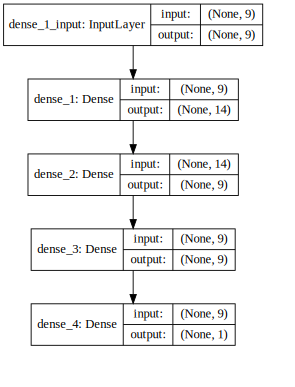

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from IPython.display import SVG
from keras.utils import model_to_dot

model = Sequential()
model.add(Dense(14, input_dim=9, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

## Training the network

We know run the training of the network and calculate and display the trainig loss and accuracy. We also use one fouth of the data for validation and calculate the validation accuracy and loss.

In [7]:
history = model.fit(X, y, validation_split=0.25, epochs=600, batch_size=14, verbose=0)
loss, accuracy = model.evaluate(X, y, verbose=0)
print("Loss: ", loss, "Accuracy: ", accuracy)

Loss:  0.04130790130235255 Accuracy:  0.9912499785423279


We visualize the training accuracy and loss history.

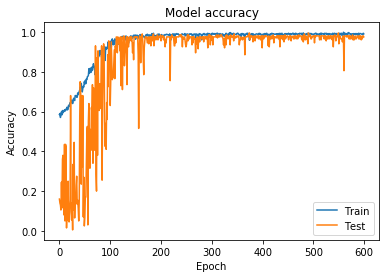

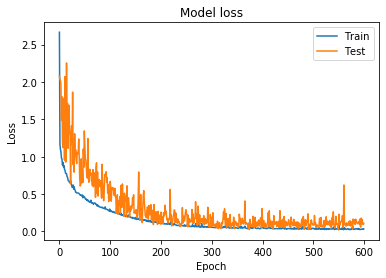

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Applying the model on images

We can now use the model to make predictions for the intensity vector of the neighborhood of a pixel.

In [43]:
prediction = model.predict(np.array([[121, 119, 127, 122, 127, 128, 115, 126, 125]]))
print(prediction[0][0])
classPrediction = model.predict_classes(np.array([[121, 119, 127, 122, 127, 128, 115, 126, 125]]))
print(classPrediction[0][0])

0.9999367
1


We will now use the model to segment images. We need to feed the neighborhood of all pixels to the classifier and create an output mask and a probability map from the result of the classification.

We set the path to the folder containing the input images. We will read each image in the folder, do the segmentation and save the result images.

Here is how it conceptually works. A loop iterates over the pixel in the input image. For each pixel a feature vector is created and classified from the intensities values in its neighborhood. It works but is very slow. We will therefore rather use an optimized version, that first creates a list of all feature vectors, passes them to the classification and then creates the mask and probability map from the results. However since the version not optimized is easier to understand, here it is:

```python
import os
path = '/media/baecker/DONNEES1/mri/in/dl-exp/data'
files = os.listdir(path)
imagePaths = [os.path.join(path, f)  for f in files if not os.path.isdir(path + "/" + f)]
imagePaths.sort()
for imagePath in imagePaths:
    image = tiff.imread(imagePath)
    width, height = image.shape
    pMap = np.zeros(image.shape)
    mask = np.zeros(image.shape)
    for x in range(0, width):
        if x%100 == 0:
            print(x)
        for y in range(0, height):
            neighborhood = []
            for i in range((-N//2)+1, (N//2)+1):
                for j in range((-N//2)+1, (N//2)+1):
                    ic = i
                    jc = j
                    if x+i < 0 or x+i>=width:
                        ic = -1 * i
                    if y+j < 0 or y+j>=height:
                        jc = -1 * j    
                    neighborhood.append(image[x+ic,y+jc])
            neighborhood = np.array([neighborhood])
            prob = model.predict(neighborhood)[0][0]
            category =  model.predict_classes(neighborhood)[0][0]
            pMap[x ,y] = prob * 255
            mask[x ,y] = category * 255
    print(pMap)
    print(mask)
```

### Making the segmentation faster

Although the segmentation above works, it is very slow. We will make it faster by applying the classification on bigger chunks of the image data, instead of classifying each pixel based on its neighborhood individually. We will first calculate the feature-vectors, i.e. the values in the neighboorhod for the whole image. Then we apply the classification. Instead of 2D output images we start with 1D arrays of size widthxheight. We fill the linear array with the classification result and then reshape it to the 2D-image.

In [137]:
%%time
import os
path = '/media/baecker/DONNEES1/mri/in/dl-exp/data'
files = os.listdir(path)
imagePaths = [os.path.join(path, f)  for f in files if not os.path.isdir(path + "/" + f)]
imagePaths.sort()
for imagePath in imagePaths:
    print("Processing image " + imagePath)
    image = tiff.imread(imagePath)
    width, height = image.shape
    neighborsRange = range((-N//2)+1, (N//2)+1)
    pMap = np.zeros(width*height)
    mask = np.zeros(width*height)
    neighborhoods = np.zeros((width*height, N*N), dtype=int)
    vc = 0
    print("Extracting the feature vectors.")
    for x in range(0, width):
        if x%10 == 0:
            print("\rColumn: " + str(x), end="")
        for y in range(0, height):
            neighborhood = np.zeros(N*N)
            nc = 0
            for i in neighborsRange:
                for j in neighborsRange:
                    ic = i
                    jc = j
                    if x+i < 0 or x+i>=width:
                        ic = -1 * i
                    if y+j < 0 or y+j>=height:
                        jc = -1 * j    
                    neighborhood[nc] = image[x+ic,y+jc]
                    nc = nc + 1
            neighborhoods[vc]=neighborhood
            vc = vc + 1
    print("\nApplying the classifier.")
    prob = model.predict(neighborhoods)
    category =  model.predict_classes(neighborhoods)
    counter = 0
    print("Creating the output images.")
    for p in prob:
        pMap[counter] = p[0] * 255
        counter = counter + 1
    counter = 0
    for c in category:
        mask[counter] = c[0] * 255
        counter = counter + 1    
    print("Done!")

Processing image /media/baecker/DONNEES1/mri/in/dl-exp/data/spots01.tif
Extracting the feature vectors.
Column: 1820
Applying the classifier.
Creating the output images.
Done!
Processing image /media/baecker/DONNEES1/mri/in/dl-exp/data/spots02.tif
Extracting the feature vectors.
Column: 1820
Applying the classifier.
Creating the output images.
Done!
CPU times: user 3min, sys: 4.87 s, total: 3min 5s
Wall time: 2min 42s


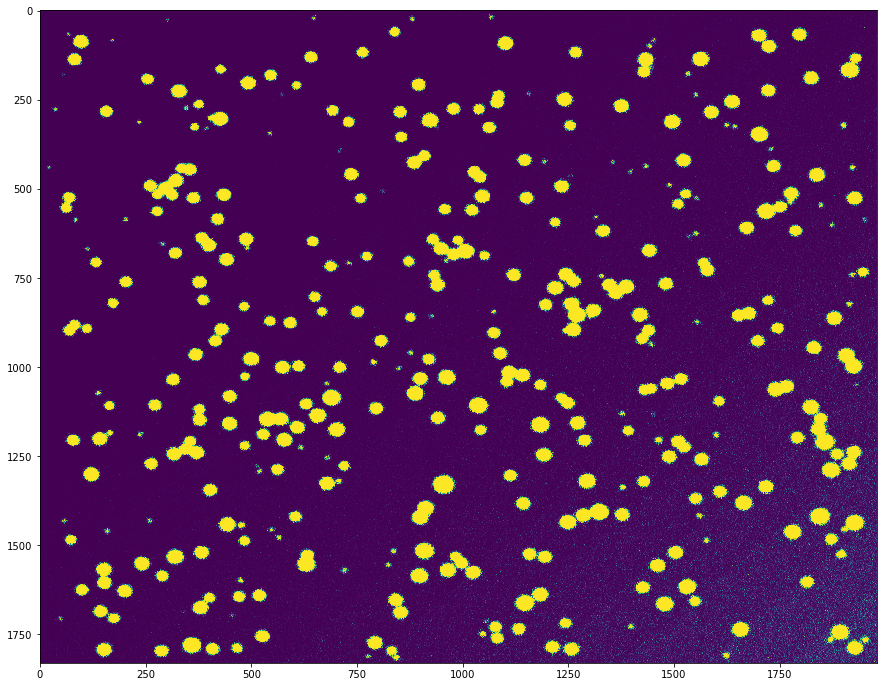

In [134]:
from matplotlib import pyplot as plt
plt.figure(figsize = (15,12))
plt.imshow(pMap, interpolation='nearest', aspect="auto")
plt.show()

## Literatur

[1] Van Rossum G, Drake FL. [Python 3 Reference Manual](https://docs.python.org/3/reference/index.html). Scotts Valley, CA: CreateSpace; 2009.

[2] Chollet F. and others. [Keras](https://keras.io). 2015

[3] [The MRI machine learning workshop](https://github.com/MontpellierRessourcesImagerie/mri-workshop-machine-learning). 2019

[4] Brownlee J. [Your First Deep Learning Project in Python with Keras Step-By-Step](https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/). 2019